## Der erste Versuch den Klang der Lochsirene zu simulieren.

Im Grunde sollte die erzeugte Schallwelle eine Faltung der Düse und der Löcher auf der Platte entsprechen. 

Hier sollen einige Geometrien getestet und in Soundfiles verwandelt werden.

In [2]:
#import required libraries

from schallwerkzeuge import *
import math
from scipy import signal
import matplotlib.pyplot as plt

In [3]:
#options for plotting

%matplotlib inline
#%matplotlib notebook
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)

In [20]:
class shepard:
    
    def __init__(self, fmin=27.5, tmax=4, cmax=8):
        self.fmin = fmin
        self.cmax = cmax
        self.tmax = tmax
        self.sound = np.empty(1,)
        
    def frequency(self, t, c):
        return self.fmin*2**((c*self.tmax + t)/self.tmax)

    def loudness(self, t, c, Lmin=1, Lmax=2):
        return(Lmin + 0.5*(Lmax-Lmin)*(1.0-np.cos(self.theta(t, c))))
    
    def amplitude(self, t, c):
        return 10**self.loudness(t, c)

    def theta(self, t,c):
        return 2*math.pi*(c*self.tmax + t)/(self.tmax*self.cmax)
    
    def generate_sound(self, duration=5.0, rate=44100):
        no_samples = int(duration*rate)
        sound_array = np.zeros((no_samples,))
        for c in range(0, self.cmax):
            for sample in range(0,no_samples):
                sound_array[sample] += self.amplitude((sample/rate), c)* \
                                      2.0*math.pi * np.sin((sample/rate) * \
                                      (self.frequency((sample/rate)%self.tmax, c)))
        self.sound = sound_array/np.max(sound_array)
        return self.sound

    def plot_f_over_t(self):
        for c in range(0, self.cmax):
            plt.plot(np.linspace(0,self.tmax,20), self.frequency(np.linspace(0,self.tmax,20), c), label = ('octave nr. ' + str(c)))
        plt.yscale('log')
        plt.xlabel('time [s]')
        plt.ylabel('frequency [Hz]')
        plt.grid()
        plt.legend()
        
    def plot_l_over_f(self, steps=10):
        t_s = np.linspace(0, self.tmax, steps)
        colors = viridis(np.linspace(0, 1, steps))
        for step in range(0, steps):
            for c in range(0, self.cmax):
                plt.scatter(self.frequency(t_s[step], c), self.loudness(t_s[step], c), color = colors[step])
        plt.xscale('log')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('amplitude [db]')


In [21]:
shep1 = shepard()

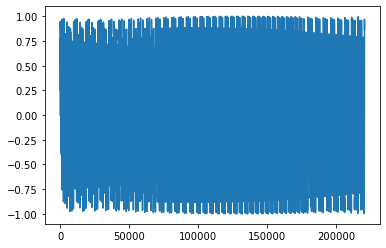

In [22]:
plt.plot(shep1.generate_sound())

In [23]:
playsnd(shep1.sound, RATE)

### Einfache Sinustone und Sweeps
Funktion die ein Array erzeugt, das beim abspielen einen Sinuston ergibt.

In [ ]:
def sinuston(freq = 220.0, duration = 4.0, sample_rate = RATE):
    no_samples = int(duration*RATE)
    sound_array = np.ndarray((no_samples,))
    for sample in range(0,no_samples):
        sound_array[sample] = math.sin((sample/RATE) * 2.0*math.pi *freq)
    return sound_array

def sweep(start_freq = 110.0, end_freq = 220.0, duration = 6.0, sample_rate = RATE):
    no_samples = int(duration*RATE)
    sound_array = np.ndarray((no_samples,))
    for sample in range(0,no_samples):
        sound_array[sample] = math.sin((sample/RATE) * \
                                       2.0*math.pi *(start_freq + sample*(end_freq-start_freq)/no_samples))
    return sound_array

In [ ]:
playsnd(sinuston(110, 10), RATE)

In [ ]:
playsnd(sweep(), RATE)

In [ ]:
base_freq = 27.5
ratio = 3.0/2.0
layers = 10
amplitude
sound_array = sweep(base_freq, base_freq*ratio, )
for layer in range(1,layers):
    sound_array = sound_array + sweep(base_freq*ratio**layer, base_freq*ratio**layers)

sound_array = sound_array/np.max(sound_array)

In [ ]:
playsnd(sound_array, RATE)

### Modell einer Lochpatte
Die Lochplatte wird in die einzelen Lochreihen aufgeteilt. Jede Lochreihe wird definiert durch ihren Kreisdurchmesser, die Lochform und eine Liste von Winkeln und Lochgrößen. Die Methode der Klasse berechnet die Faltung aus Düse und der Lochreihe, um in erster Näherung eine Idee des entstehenden Klanges zu bekommen.

__Alle Maße in Millimeter!__

In [ ]:
class lochreihe:
    
    def __init__(self, durchmesser_reihe, loecher_liste, lochform):
        self.dr = durchmesser_reihe
        self.winkel = np.array(loecher_liste)[:,0]
        self.lochradien = np.array(loecher_liste)[:,1]
        self.lf = lochform
        self.duese_diam = 2.0

        self.spatial_res = 0.05
        self.stripe = []
        self.kernel = []
        self.pix_x = int(self.dr * math.pi / self.spatial_res)
        self.pix_y = int(np.max(self.lochradien)*2.0 / self.spatial_res)
        self.sound = []
        
            
    def sound_array(self):
        
        self.generate_matrices()
        self.sound = signal.convolve2d(self.stripe, self.kernel, boundary='wrap', mode='valid')
        return np.transpose(self.sound/np.max(self.sound))
        
    def generate_matrices(self):
        
        self.stripe = np.zeros((self.pix_x, self.pix_y))
        self.kernel = np.zeros((self.pix_y,self.pix_y))        
        
        print('render kernel ', self.pix_y, ' pixels in x, ', self.pix_y, ' pixels in y')
        self.print_circle(self.kernel, np.max(self.lochradien), np.max(self.lochradien), self.duese_diam)
        plt.imshow(self.kernel)
        
        print('render stripe ', self.pix_x, ' pixels in x, ', self.pix_y, ' pixels in y')
        for index, (bogen, lochradius) in enumerate(zip(self.winkel*self.dr*math.pi, self.lochradien)):
            #print('generate hole nr ', index)
            self.print_circle(self.stripe, bogen , np.max(self.lochradien), lochradius)
        plt.imshow(np.transpose(self.stripe))
        
        
    def print_circle(self, matrix, x_pos_mm, y_pos_mm, diam_mm):
        
        x_pos_pix = int(0.5 + (x_pos_mm / self.spatial_res))
        y_pos_pix = int(0.5 + (y_pos_mm / self.spatial_res))
        radius_pix = int(0.5 + (diam_mm / self.spatial_res)/2)      

        xlim = (x_pos_pix-radius_pix, x_pos_pix+radius_pix)
        ylim = (y_pos_pix-radius_pix, y_pos_pix+radius_pix)
        for i in range(*xlim):
            for j in range(*ylim):
                if math.sqrt((i-x_pos_pix)**2 + (j-y_pos_pix)**2) < radius_pix:
                    matrix[i%self.pix_x,j%self.pix_y] = 1.0
       

In [ ]:
durchmesser_reihe = 300
lochform = 'o'
loecher_liste = []

n = 50
for i in range(0,n):
    loecher_liste.append([i/n, 5])

In [ ]:
test_object = lochreihe(durchmesser_reihe, loecher_liste, lochform)

In [ ]:
test_object.sound_array()

In [ ]:
%matplotlib notebook
plt.plot(test_object.sound/np.max(test_object.sound))
plt.show()

In [ ]:
playsnd_continuous(test_object.sound/np.max(test_object.sound), RATE)